<a href="https://colab.research.google.com/github/tusharganguli/anomaly_detection/blob/main/ad_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Anomaly Detection
This is notebook is a step by step guide of various methods that can be implemented for anomaly detection.

**References**
- [Medium: Anomaly Detection in Time Series using ChatGPT](https://medium.com/@sztistvan/anomaly-detection-in-time-series-using-chatgpt-3fc48f958c88)
- [Medium: Isolation Forest](https://medium.com/@corymaklin/isolation-forest-799fceacdda4)
- [Medium: Introduction To Anomaly Detection Methods](https://medium.com/@jelkhoury880/introduction-to-anomaly-detection-methods-part-i-b1a2f389ffcb)
- [Kaggle: Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/datasets/boltzmannbrain/nab)
- [Kaggle: Unsupervised Anomaly Detection](https://www.kaggle.com/code/victorambonati/unsupervised-anomaly-detection)


##Statistical Techniques

**Dataset**

*Numenta Anomaly Benchmark (NAB)*: Contains a variety of real-world time series data with labeled anomalies. We will use "*machine_temperature_system_failure.csv*" dataset which consists of temperature readings from a machine in an industrial setting.

What is the **Numenta Anomaly Benchmark (NAB)** dataset and how can I access it?

The **Numenta Anomaly Benchmark (NAB)** is a benchmark dataset developed by the research team at Numenta to evaluate anomaly detection algorithms. The dataset consists of real-world time-series data that have been labeled with anomalies, making it useful for testing and comparing different anomaly detection algorithms. The dataset includes a variety of data types, including server metrics, network traffic, and environmental sensor data.

To access the NAB dataset, you can visit the official website at **https://github.com/numenta/NAB**. The dataset is available for free and can be downloaded from the Github repository. The dataset comes with a set of Python scripts that can be used to evaluate the performance of different anomaly detection algorithms on the dataset. The website also provides documentation and examples to help you get started with using the dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv')

# Convert the timestamp column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])


###Moving Average (MA)

The MA technique calculates the moving average of the data over a specified time window and detects anomalies based on deviations from the moving average.

The following code will load the dataset, convert timestamp column to a datetime object, calculate moving average of temperature readings, calculate deviation from moving average, calculate standard deviation, calculate threshold for anomaly detection, detect anomalies based on deviations from moving average, and plot the temperature readings and anomalies.

The code also plots the moving average and threshold for anomaly detection as a gray shaded region.

In [ ]:

def moving_average(df):
  # Calculate the moving average of the temperature readings
  window_size = 200 # MODIFICATION, 50
  ma = df['value'].rolling(window_size).mean()

  # Calculate the deviation from the moving average
  deviation = df['value'] - ma

  # Calculate the standard deviation of the deviation
  std_deviation = deviation.rolling(window_size).std()

  # Calculate the threshold for anomaly detection
  threshold = 3 * std_deviation

  # Detect anomalies based on deviations from the moving average
  anomalies = df[deviation.abs() > threshold]
  return [anomalies,ma,threshold]

In [ ]:
def plot(df,anomalies, mean,threshold):
  # Plot the temperature readings and the anomalies
  plt.subplots(figsize=(14, 10))
  plt.plot(df['timestamp'], df['value'], color='blue', label='Temperature Readings')
  plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies')
  plt.fill_between(df['timestamp'], mean-threshold, mean+threshold, color='gray', alpha=0.2, label='Threshold')
  plt.legend()
  plt.title('Machine Temperature Anomaly Detection')
  plt.xlabel('Date')
  plt.ylabel('Temperature (Celsius)')
  plt.grid()
  plt.show()

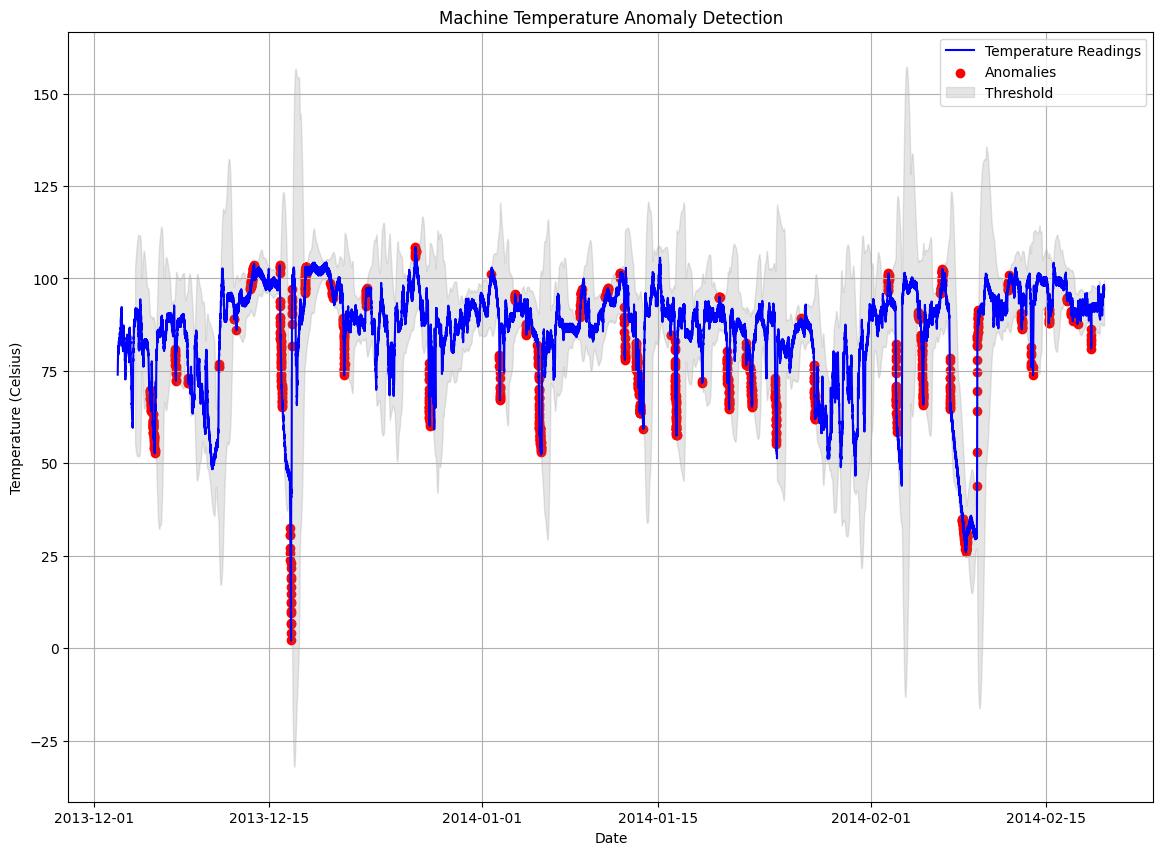

In [ ]:
anomalies,ma,threshold = moving_average(df)
plot(df,anomalies,ma,threshold)

Why did we use threshold 3 times the standard deviation?

The choice of using 3 times the standard deviation as a threshold is because in a normal distribution approximately 99.7% of the data falls within three standard deviations of the mean.

Setting threshold at mean plus or minus 3 times the standard deviation captures majority of the data in a normal distribution. This threshold is often used in statistical analysis to identify outliers or extreme values in a dataset.

However, it's important to note that this rule may not always be appropriate for all datasets, particularly if the distribution is not normal or if the data has outliers. In these cases, alternative methods for setting thresholds may be more appropriate.

### Z-Score Analysis
The Z-score is a statistical measure that tells you how far away a single data point is from the mean of a data set. In a standard normal distribution, data points that fall far from the mean (typically more than 2 or 3 standard deviations away) are considered outliers or anomalies.

The Z-score of a data point $x$ is calculated as:
\begin{equation}
  Z_{score} = \frac{x-\mu}{\sigma}
\end{equation}

A Z-score can be positive or negative, indicating whether the data point is above or below the mean. In anomaly detection, Z-scores that are far away from zero (typically, an absolute value greater than 2 or 3) indicate anomalies.

In [ ]:
import numpy as np

def calculate_zscore(df):
  # Calculate the average of the temperature readings
  mean = df['value'].mean()

  # Calculate the deviation from the average
  deviation = df['value'] - mean

  # Calculate the standard deviation of the deviation
  std_deviation = deviation.std() # same as we would calculate df['value'].std()

  # Calculate Z-score - we don't use it directly, just for reference
  z_score = deviation / std_deviation # z_score = (value-mean)/std

  # Calculate the threshold for anomaly detection
  # equivalent to saying: threshold = 3 * std_deviation
  threshold = 3

  # Detect anomalies based on deviations from the moving average
  #anomalies = df[deviation.abs() > threshold]
  anomalies = df[np.abs(z_score) > threshold]
  return [anomalies,mean,threshold*std_deviation]



In [ ]:
anomalies,mean,threshold = calculate_zscore(df)
plot(df,anomalies,mean,threshold)

### Percentile Analysis

In [ ]:
def percentile_analysis(df):
  # calculate percentile limits
  percent_limit = 0.3 # 99.7% is set
  upper_threshold = df['value'].quantile((100-percent_limit/2)/100)
  lower_threshold = df['value'].quantile(percent_limit/2/100)

  # Detect anomalies based on percentile limits
  anomalies_upper = df[df['value'] > upper_threshold]
  anomalies_lower = df[df['value'] < lower_threshold]

  # Plot the temperature readings and the anomalies
  plt.subplots(figsize=(14, 10))
  plt.plot(df['timestamp'], df['value'], color='blue', label='Temperature Readings')
  plt.scatter(anomalies_upper['timestamp'], anomalies_upper['value'], color='cyan', label='Upper anomalies')
  plt.scatter(anomalies_lower['timestamp'], anomalies_lower['value'], color='red', label='Lower anomalies')
  plt.fill_between(df['timestamp'], lower_threshold, upper_threshold, color='gray', alpha=0.2, label='Threshold')
  plt.legend()
  plt.title('Machine Temperature Anomaly Detection - Percentiles')
  plt.xlabel('Date')
  plt.ylabel('Temperature (Celsius)')
  plt.grid()
  plt.show()


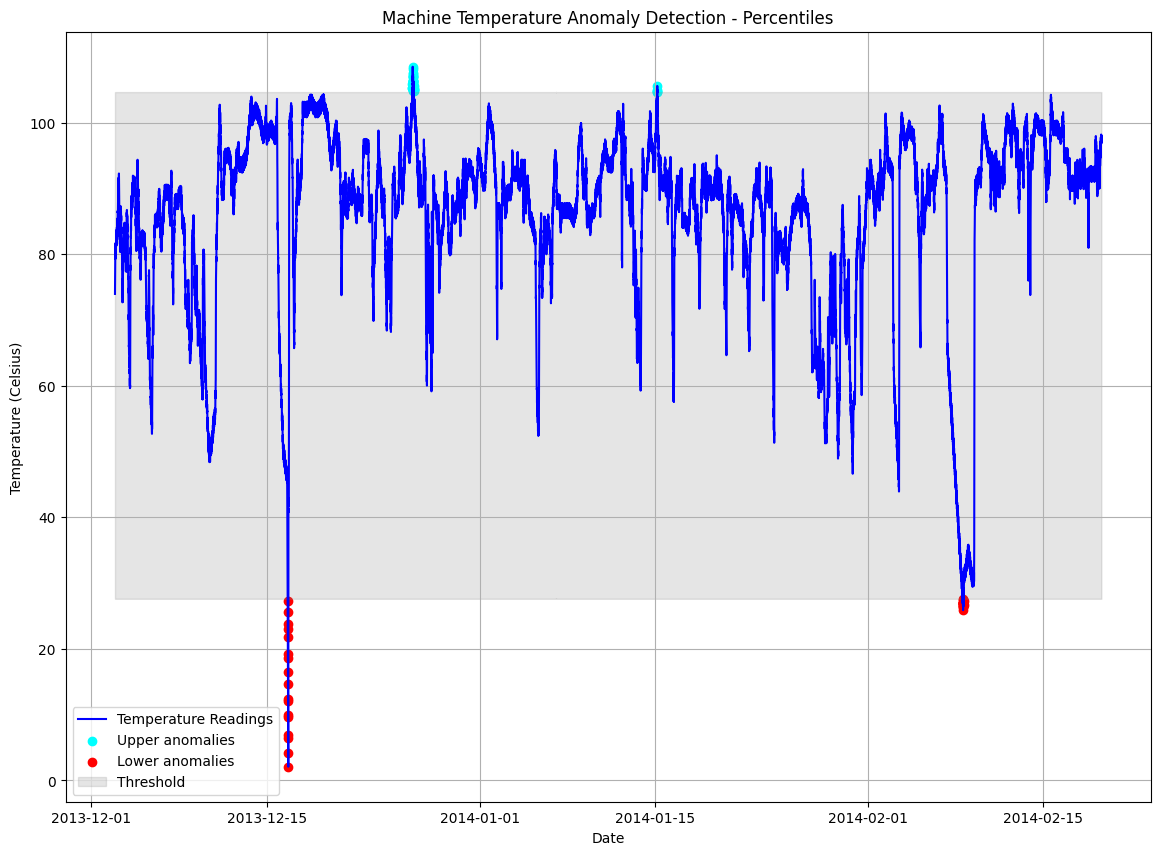

In [ ]:
percentile_analysis(df)

## Classical Machine Learning Algorithms

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv')

# Convert the timestamp column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set the timestamp column as the index and convert to a series
series = df.set_index('timestamp')['value'].squeeze()

### Isolation Forest
Isolation Forest belongs to the type of unsupervised machine learning algorithms. It uses an ensemble of decision trees to isolate anomalous points in the data.

Here's how the algorithm works:

1. Randomly select a feature and a split point in the feature space.
2. Partition the data into two groups using the feature and split point.
3. Repeat steps 1 and 2 recursively on the resulting partitions until each point is isolated in its own partition.
4. The number of partitions it takes to isolate a point is a measure of how anomalous that point is.

**Points that can be isolated with fewer partitions are considered more anomalous**.

In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest

def detect_anomalies_with_isolation_forest(series):
    # Convert the series to a 2D NumPy array
    data = series.values.reshape(-1, 1)

    # Create an instance of IsolationForest class
    model = IsolationForest(n_estimators=100, contamination=0.01, random_state=45)

    # Fit model to the data
    model.fit(data)
    # predict anomalies
    anomalies = model.predict(data)

    # Convert predictions to series
    anomalies_series = pd.Series(anomalies, index=series.index)
    return anomalies_series

**Isolation Forest parameters**
- `n_estimators`: This is the number of decision trees that will be used in the Isolation Forest algorithm. Increasing this value will generally lead to better performance, but will also increase the computational complexity and runtime of the algorithm.

- `max_samples`: This is the number of samples that will be used to build each decision tree in the Isolation Forest algorithm. Increasing this value will generally lead to better performance, but may also increase the risk of overfitting.

- `contamination`: This is the fraction of the input data that is assumed to be anomalous. This parameter is used to determine the decision threshold for classifying a data point as an anomaly. A lower value of contamination will result in a higher decision threshold, meaning that fewer data points will be classified as anomalies. A higher value of contamination will result in a lower decision threshold, meaning that more data points will be classified as anomalies.

- `max_features`: This is the maximum number of features that will be used to build each decision tree in the Isolation Forest algorithm. This parameter is used to control the diversity of the decision trees. A higher value of max_features will result in more diverse decision trees, but may also increase the computational complexity and runtime of the algorithm.

- `bootstrap`: This parameter controls whether or not the training data will be bootstrapped when building each decision tree in the Isolation Forest algorithm. Bootstrapping can help to improve the diversity of the decision trees and reduce the risk of overfitting.

- `random_state`: This parameter is used to set the random seed for the Isolation Forest algorithm. Setting this parameter to a fixed value will ensure that the algorithm produces consistent results across multiple runs, which can be useful for debugging and reproducibility.


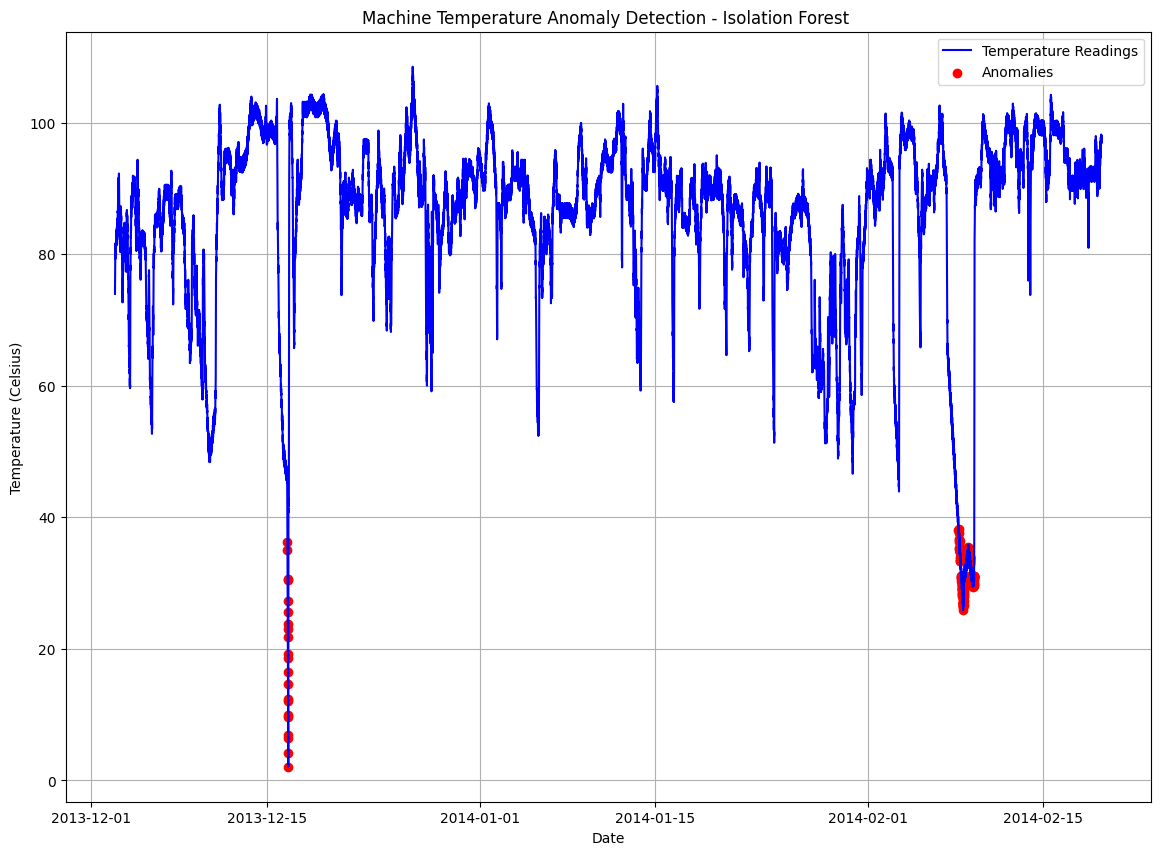

In [ ]:
# Detect anomalies using the Isolation Forest algorithm
anomalies = detect_anomalies_with_isolation_forest(series)

# Plot the original series and the detected anomalies
plt.subplots(figsize=(14, 10))
plt.plot(df['timestamp'], df['value'], color='blue', label='Temperature Readings')
plt.scatter(anomalies[anomalies==-1].index, series[anomalies==-1].values, color='red', label='Anomalies')
plt.legend()
plt.title('Machine Temperature Anomaly Detection - Isolation Forest ')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()


### Local Outlier Factor
The Local Outlier Factor (LOF) algorithm is a density-based anomaly detection method that is designed to detect local outliersâ€”that is, anomalies that may not be outliers when compared to the entire dataset but are outliers within their local neighborhood. LOF works well for datasets where the density of the data points is not uniform.

**Algorithm**:

1. k-Nearest Neighbors:
The algorithm starts by calculating the k-nearest neighbors for each data point. The distance can be calculated using various methods such as Euclidean distance, Manhattan distance, etc.

2. Local Reachability Density (LRD):
The local reachability density (LRD) of a data point is a measure of how densely the point is packed with its neighbors. LRD is computed as the inverse of the average reachability distance of the point from its k-nearest neighbors. The reachability distance between a point A and point B is defined as:

$Reachability\; Distance_k$ (A,B) = max(distance to $k^{th}$ nearest neighbor of A,distance from A to B)

3. LOF Calculation:
The LOF of a data point $A$ is the average ratio of the LRDs of A's k-nearest neighbors to A's own LRD:
\begin{equation}
  LOF_K(A) = \frac{1}{k} \sum_{B \in neighbors\;of\;A} \frac{LRD(B)}{LRD(A)}
\end{equation}

If LOF(A) is approximately 1, then A is roughly as dense as its neighbors.

If LOF(A) is much less than 1, then A is denser than its neighbors (not an outlier).

If LOF(A) is much greater than 1, A is much less dense than its neighbors (an outlier).


In [ ]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

def detect_anomalies_with_local_outlier(series):
    lof = LocalOutlierFactor(n_neighbors=40, contamination=0.01)
    X = series.values.reshape(-1,1)
    y_pred = lof.fit_predict(X)
    anomalies = X[y_pred==-1]
    return pd.Series(anomalies.flatten(), index=series.index[y_pred==-1])


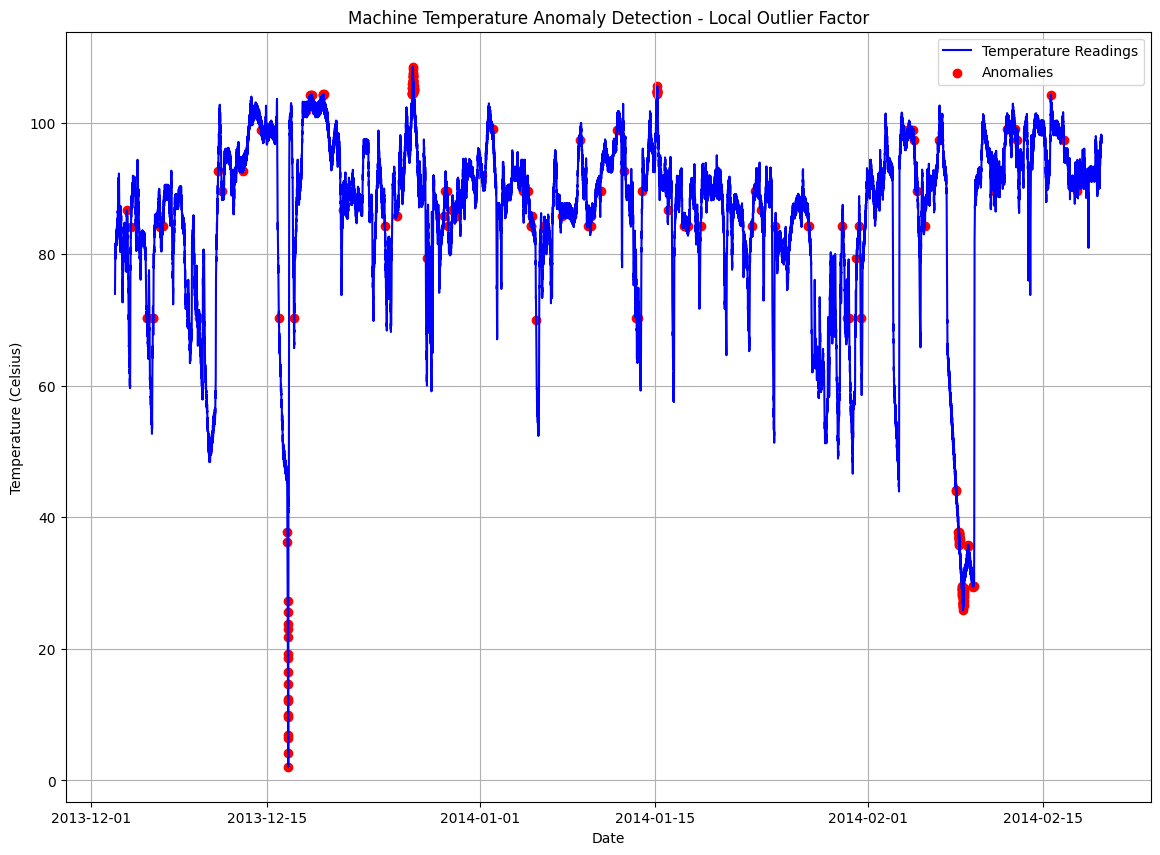

In [ ]:
# Detect anomalies using the Isolation Forest algorithm
anomalies = detect_anomalies_with_local_outlier(series)

# Plot the original series and the detected anomalies
plt.subplots(figsize=(14, 10))
plt.plot(df['timestamp'], df['value'], color='blue', label='Temperature Readings')
plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.legend()
plt.title('Machine Temperature Anomaly Detection - Local Outlier Factor')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()


Parameters used in the Local Outlier Factor (LOF) algorithm:

- `n_neighbors`: The number of neighbors used to calculate the local density of each data point. Increasing this value will make the algorithm less sensitive to isolated data points, but may also result in a loss of sensitivity to local outliers. A good rule of thumb is to set this parameter to the smallest value that still captures the local structure of the data.

- `contamination`: The expected proportion of outliers in the data. This parameter is used to set a threshold on the LOF scores, below which data points are considered outliers. The default value of `contamination` is 0.1, which assumes that 10% of the data points are outliers. However, you should adjust this parameter based on the specific characteristics of your data.

In general, you should first set the `n_neighbors` parameter based on the local structure of your data, and then adjust the `contamination` parameter to achieve a desired level of sensitivity to outliers. However, it's important to note that the LOF algorithm is not always guaranteed to work well on all types of data, and you may need to experiment with different parameter settings and outlier detection methods to find the best approach for your specific use case.


### Autoencoder algorithm

Autoencoders are a type of neural network architecture often used for dimensionality reduction, denoising, and feature learning. In the context of anomaly detection, autoencoders can be trained to capture the common or 'normal' characteristics of the data. Then, the model can be used to detect anomalies by identifying data points that the autoencoder struggles to reconstruct accurately.

**Architecture of an Autoencoder**:
1. **Encoder**: This part of the network compresses the input into a latent-space representation. It encodes the input as an internal fixed-size representation in reduced dimensionality. The encoder phase maps the input data $x$ to a latent variable $z$, through a function $f$
\begin{equation}
  z = f(x)
\end{equation}

2. **Decoder**: This part of the network reconstructs the input data from the internal representation. It maps the encoded data back to the original data space. The decoder phase reconstructs the input data
$x$ from the latent representation $z$, through a function:
\begin{equation}
  x^{'} = g(z)
\end{equation}

**How Autoencoders are Used for Anomaly Detection**:
1. **Training**: During the training phase, the autoencoder learns to encode the 'normal' training data into lower dimensions and then decode it back to the original data with minimal loss. The model is trained to minimize a loss function, often the Mean Squared Error (MSE), which measures the difference between the input $x$ and the reconstructed output $x^{'}$:
\begin{equation}
  MSE = \frac{1}{n}\sum_{i=1}^{n}(x_i-x_i^{'})^2
\end{equation}


2. **Evaluation**: During the evaluation phase, the trained autoencoder takes in new data and attempts to reconstruct it. For 'normal' data points, the reconstruction error should be low, while for anomalous data points, the error is expected to be high.

3. **Thresholding**: A threshold is established based on the reconstruction error of the training (normal) data. Data points that have a reconstruction error higher than this threshold are flagged as anomalies.

**Discussion**

For using autoencoder for anomaly detection we need training data which has no anomalies. This data should be used to train the network. However, as we do not have any information of which portion of the data is free of anomaly we will assume that a certain part of the data does not have anomaly and train the network on that data.

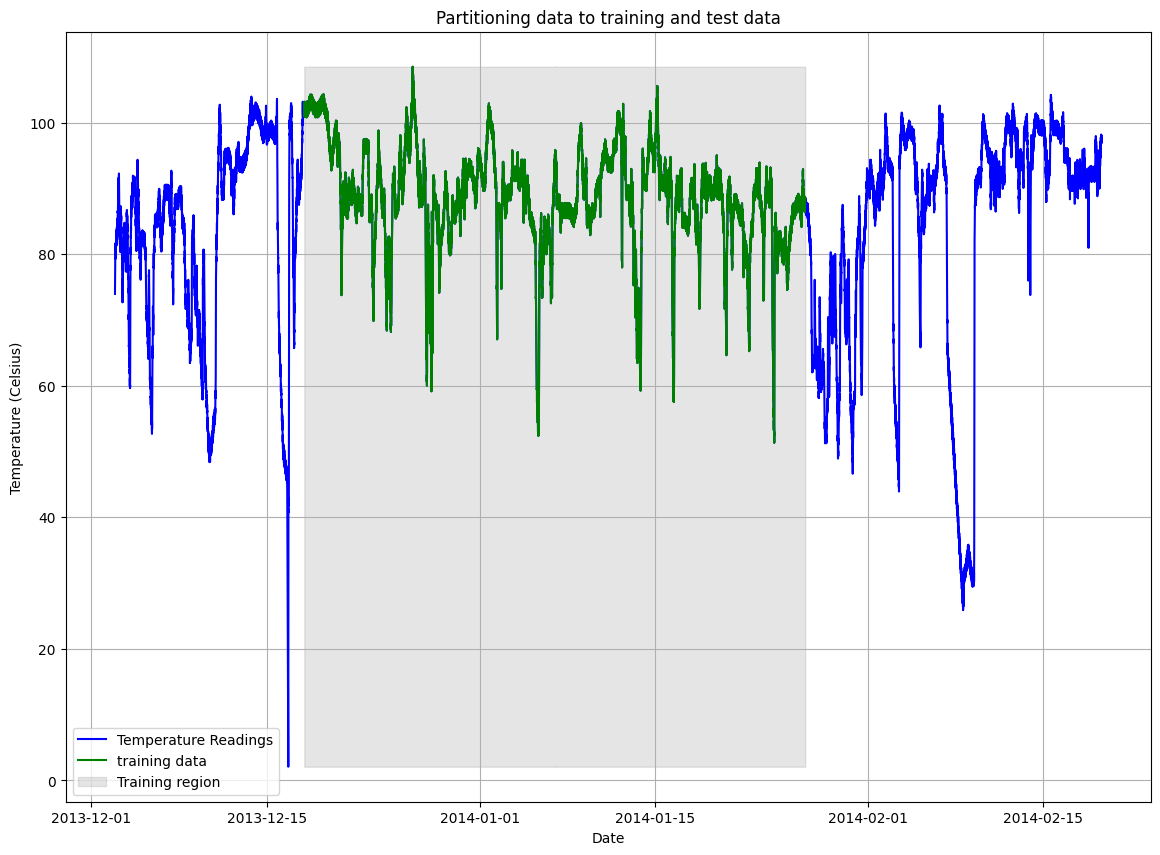

In [ ]:
train_series = series.loc['2013-12-18':'2014-01-26']
test_series = series # Run on all data

min_val = series.min()
max_val = series.max()

# Plot the original series and the detected anomalies
plt.subplots(figsize=(14, 10))
plt.plot(df['timestamp'], df['value'], color='blue', label='Temperature Readings')
plt.plot(train_series.index, train_series.values, color='green', label='training data')
plt.fill_between(train_series.index, min_val, max_val, color='gray', alpha=0.2, label='Training region')
plt.legend()
plt.title('Partitioning data to training and test data')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()

In [ ]:
from tensorflow import keras

def build_autoencoder(window_size=20, latent_dim=3):
    """
    Build a simple autoencoder
    """
    # Define the autoencoder architecture
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(window_size,)),
        keras.layers.Dense(latent_dim, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(window_size, activation='linear')
    ])
    return model

In [ ]:
from tensorflow import keras

def train_autoencoder(train_series, model, window_size=20, epochs=100):
    """
    Train the  autoencoder
    """
    # Prepare the input data
    X = []
    for i in range(len(train_series) - window_size):
        X.append(train_series[i:i+window_size])
    X = np.array(X)

    # Train the autoencoder
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, X, epochs=epochs, verbose=0)
    return model

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras

def detect_anomalies(test_series, model, window_size=20):
    # Prepare the input data
    X = []
    for i in range(len(test_series) - window_size):
        X.append(test_series[i:i+window_size])
    X = np.array(X)

    # Use the trained autoencoder to detect anomalies
    X_pred = model.predict(X)
    mse = np.mean(np.power(X - X_pred, 2), axis=1)
    threshold = np.percentile(mse, 95)
    anomalies = test_series.iloc[window_size:][mse >= threshold]

    return anomalies


705/705 [==============================] - 1s 1ms/step


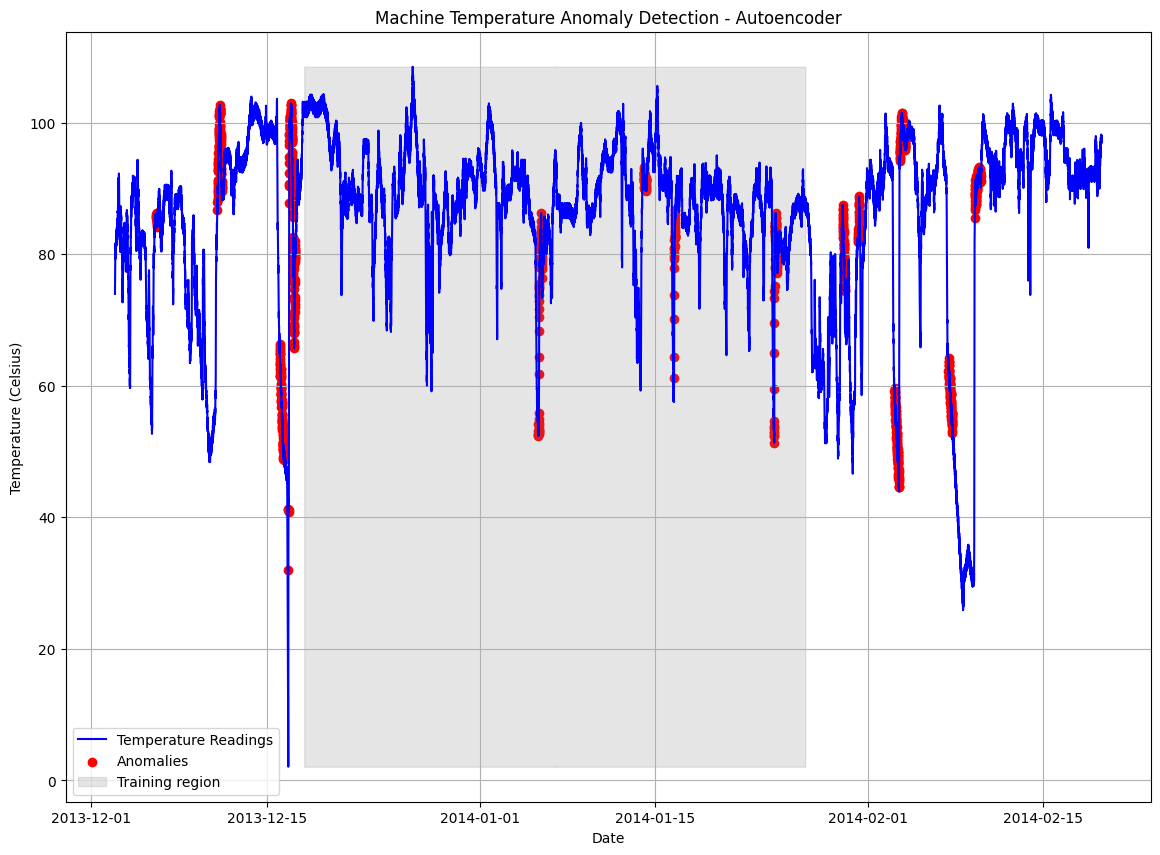

In [ ]:
# Detect anomalies using Autoencoder - 2

# Select training data
train_series = series.loc['2013-12-18':'2014-01-26']
test_series = series # Run on all data

min_val = series.min()
max_val = series.max()

# Set autoencoder parameters
window_size = 150
latent_dim = 3
epochs = 100

# Build a simple autoencoder
model = build_autoencoder(window_size, latent_dim)

# Train the  autoencoder
model = train_autoencoder(train_series, model, window_size, epochs)

# Detect anomalies using the Isolation Forest algorithm
anomalies = detect_anomalies(test_series, model, window_size)

# Plot the original series and the detected anomalies
plt.subplots(figsize=(14, 10))
plt.plot(df['timestamp'], df['value'], color='blue', label='Temperature Readings')
plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.fill_between(train_series.index, min_val, max_val, color='gray', alpha=0.2, label='Training region')
plt.legend()
plt.title('Machine Temperature Anomaly Detection - Autoencoder')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()

##Time Series Specific Methods

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv')

# Convert the timestamp column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set the timestamp column as the index and convert to a series
series = df.set_index('timestamp')['value'].squeeze()

### ARIMA

**ARIMA (AutoRegressive Integrated Moving Average)**

ARIMA is a statistical model used for time series forecasting. The ARIMA model captures different aspects of the time series data such as seasonality, trend, and noise, by combining three components: AutoRegressive (AR), Integrated (I), and Moving Average (MA).

**Components**
1. **AR (AutoRegressive)**: Captures the relationship between an observation and its lagged observations (previous time steps).
\begin{equation}
   X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + e_t
\end{equation}
2. **I (Integrated):** Differencing the series to make it stationary.
\begin{equation}
    \Delta X_t = X_t - X_{t-1}
\end{equation}
3. **MA (Moving Average):** Models the relationship between an observation and the residual errors from previous observations.
\begin{equation}
    X_t = \mu + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + \ldots + \theta_q e_{t-q}
\end{equation}

**How to Use ARIMA for Anomaly Detection**

1. **Data Preprocessing**: Make sure your time series data is stationary. You may need to perform transformations like differencing or taking the logarithm of the series.
2. **Model Fitting**: Fit an ARIMA model to your time series data. You'll need to determine the order of each component (AR, I, MA), denoted as $(p,d,q)$.
3. **Residual Analysis**: After fitting, calculate the residuals $(e_t)$ which is the difference between the observed values and the values predicted by the model. $e_t = X_t-\hat{X}_t$
4. **Threshold Setting**: Calculate the standard deviation $(\sigma)$ of the residuals. Anomalies can then be identified if the absolute value of a residual is higher than a certain threshold, often defined as $\sigma \times k$, where $k$ is a constant.

Anomaly Detection: Use the trained ARIMA model to forecast future points in the time series. Calculate the residuals for these points and flag those with residuals exceeding the threshold as anomalies.

**Advantages**:
* Good for capturing linear relationships in the time series.
* Does not require large datasets for training.

**Disadvantages**:
* Assumes linear relationships and might not perform well for more complex or non-linear data.
* The choice of parameters $(p,d,q)$ often requires domain knowledge or grid search, which can be computationally intensive.

ARIMA models are widely used for anomaly detection in various domains like finance for detecting fraudulent transactions, in manufacturing for quality control, and in IT for system health monitoring.


**Stationarity**

In time series analysis, a stationary series is one whose statistical properties like mean, variance, and autocorrelation are all constant over time. In simpler terms, the series does not exhibit trends or seasonality. Stationarity is an important assumption for many time series models, including ARIMA (AutoRegressive Integrated Moving Average).

ARIMA model assumes that the underlying data is stationary. If the data is not stationary, the model's forecasts can be inaccurate or misleading. Non-stationary data often contain trends or seasonal patterns. For example, sales data could increase over time due to company growth, or temperature data could exhibit seasonal patterns (e.g., warmer in summer and colder in winter). If you attempt to model these data without making them stationary, the model will not capture these underlying patterns effectively.

The "Integrated" component in ARIMA is designed to help with this issue. By differencing the data (subtracting the current value from the previous value), the model aims to make the series stationary if it isn't already. The "order of differencing" (the "I" in ARIMA) indicates how many times differencing is performed to make the series stationary. However, differencing is not always sufficient to make a series stationary, and additional transformations may be needed.

In summary, ensuring that the data are stationary is critical for the performance of ARIMA models. This is why one of the initial steps in applying ARIMA is to check for stationarity and to apply differencing or other transformations to stabilize the mean and variance across the time series.

**Check for Stationarity**
1. Plotting the data to visualize trends or seasonality.
2. Performing statistical tests like the Augmented Dickey-Fuller test.
3. Examining the autocorrelation and partial autocorrelation plots.

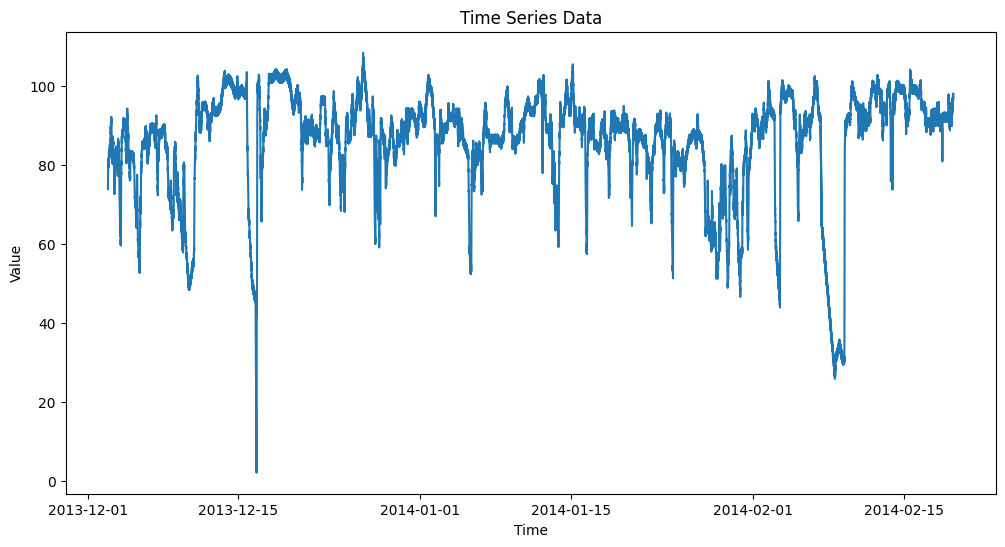

ADF Statistic: -7.3690895644913414
p-value: 9.071345315518266e-11
Critical Values: {'1%': -3.4306384378792365, '5%': -2.861667480233377, '10%': -2.566837854101014}
The series is stationary.


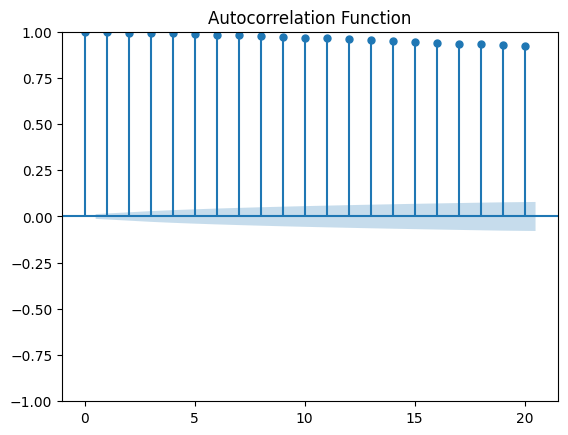

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Plot the data
plt.figure(figsize=(12, 6))
plt.plot(series.index, series.values)
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Step 2: Perform Augmented Dickey-Fuller test
result = adfuller(series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] <= 0.05:
    print('The series is stationary.')
else:
    print('The series is not stationary.')

# Step 3: Plot ACF and PACF
plot_acf(series, lags=20)
plt.title('Autocorrelation Function')
plt.show()

plot_pacf(series, lags=20)
plt.title('Partial Autocorrelation Function')
plt.show()


**Explanation**

The Augmented Dickey-Fuller (ADF) test is commonly used to test for stationarity in a time series. The ADF statistic is -7.37, which is well below the critical values at the 1%, 5%, and 10% levels. The p-value is also extremely low (9.07e-11), well below any conventional significance level. These findings strongly reject the null hypothesis of the ADF test, which assumes that the series has a unit root and is therefore non-stationary. Data is very likely to be stationary based on this test.

The ACF shows steady values close to 1. It typically indicates non-stationarity, but ADF test shows that the series is stationary. This might seem like a contradiction. There can be multiple explanations for this apparent discrepancy:

The ADF test has higher statistical power, making it more reliable for detecting non-stationarity. Therefore, the series could actually be stationary despite the ACF pattern.

It could be that the ACF is showing high autocorrelation due to some other form of dependence that doesn't violate stationarity. There may be other nuances or complexities in the data that aren't fully captured by these simple diagnostic tools.

The quick decay in the PACF suggests that the data could be an $AR(1)$ model for this time series data.

To summarize:

The series is likely stationary according to the ADF test.
Despite the ACF pattern, which usually indicates non-stationarity, the strong ADF result suggests that the data is actually stationary.
The PACF suggests that an $AR(1)$ model may be a good fit for the data.

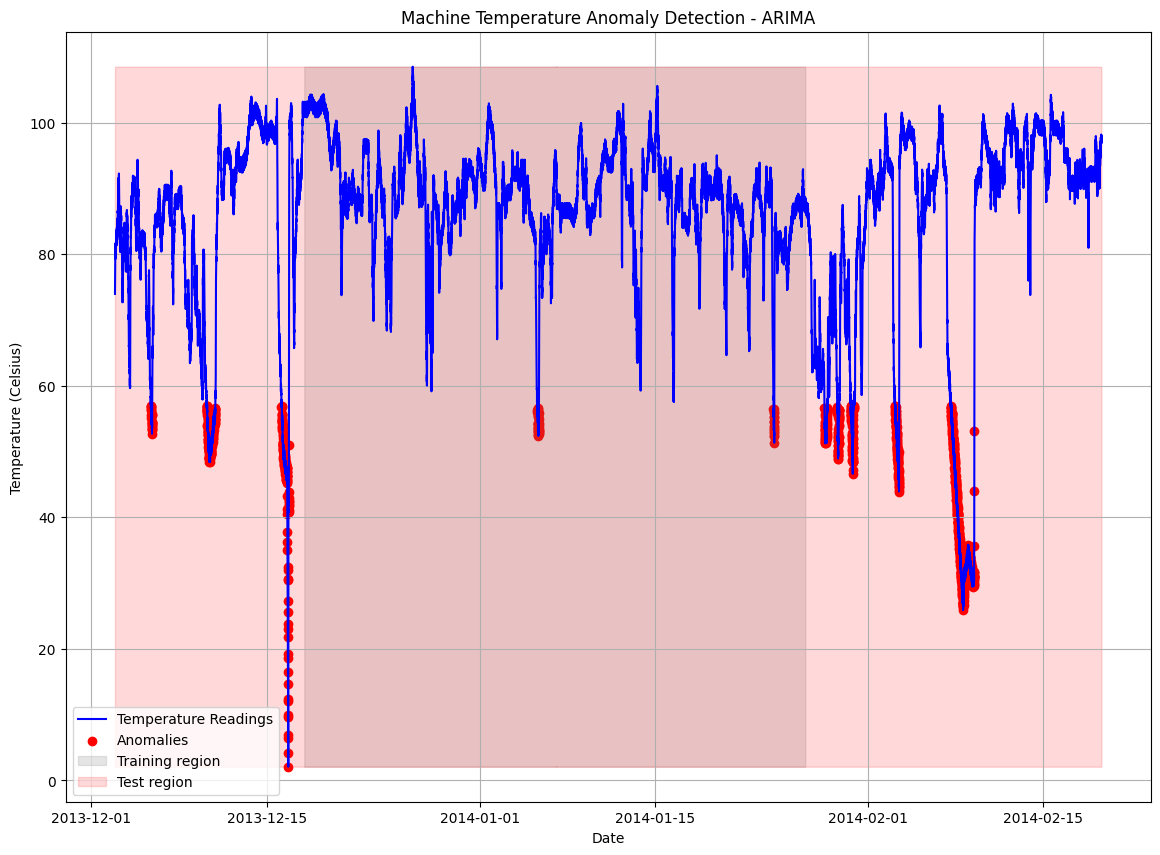

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

min_val = series.min()
max_val = series.max()

# Split the data into training and testing sets
train_series = series.loc['2013-12-18':'2014-01-26']
test_series = series.loc['2014-01-22':] # some overlapping

# ---------------------- CHATGPT ---------------------- :
# Fit an ARIMA model to the training data
#model = ARIMA(train_series.values, order=(3,1,1))
model = ARIMA(train_series.values, order=(1,0,0))
model_fit = model.fit()

# Make predictions on the testing data
predictions = model_fit.forecast(steps=len(test_series))[0] # ORIGINAL - resulting a single step prediction
predictions = model_fit.forecast(steps=len(test_series))

# Calculate the residuals between the predicted and actual values
residuals = test_series.values - predictions

# Calculate the mean and standard deviation of the residuals
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

# Determine the threshold for anomaly detection
threshold = residual_mean + 2.5 * residual_std

# Identify anomalies in the testing data
anomalies = test_series[abs(residuals) > threshold]
# ---------------------- CHATGPT ----------------------

# Plot the original series and the detected anomalies
plt.subplots(figsize=(14, 10))
plt.plot(df['timestamp'], df['value'], color='blue', label='Temperature Readings')
plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.fill_between(train_series.index, min_val, max_val, color='gray', alpha=0.2, label='Training region')
plt.fill_between(test_series.index, min_val, max_val, color='red', alpha=0.15, label='Test region')
#plt.plot(test_series.index, predictions, color='green', label='Predictions')
plt.legend()
plt.title('Machine Temperature Anomaly Detection - ARIMA')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()

**Hint**: the line `predictions = model_fit.forecast(steps=len(test_series))[0]` results in a single step prediction value only. This single value will be compared to the values in the test data. Similarly as if we calculated the mean of data. It does not help if we generated a whole series: `predictions = model_fit.forecast(steps=len(test_series)) `. Such a linear model will not be able to predict this well for such a long time. This would require further modifications.